In [ ]:
!pip install efficientnet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
import os
import glob
from google.colab import drive
from efficientnet.keras import EfficientNetB3  # Import EfficientNet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Mount Google Drive
drive.mount('/content/drive')

# Set the path to your spectrogram images and labels
spectrogram_folder = '/content/drive/MyDrive/nandu/SPECTROGRAMS/'
labels_folder = '/content/drive/MyDrive/nandu/LABELS/'
batch_size = 32

# Analyze data structure and classes
class_folders = glob.glob(os.path.join(spectrogram_folder, '*'))
num_classes = len(class_folders)

spectrogram_files = []
labels = []

for class_folder in class_folders:
    class_name = os.path.basename(class_folder)
    label_folder = os.path.join(labels_folder, class_name)
    
    label_files = glob.glob(os.path.join(label_folder, '*.txt'))
    
    if len(label_files) > 0:
        for label_file in label_files:
            with open(label_file, 'r') as f:
                label = f.read().strip()
                labels.append(label)

            subfolder = os.path.basename(os.path.dirname(label_file))
            png_files = glob.glob(os.path.join(spectrogram_folder, class_name, subfolder, '*.png'))
            spectrogram_files.extend(png_files)

num_samples = len(spectrogram_files)

print("Number of spectrogram samples:", num_samples)
print("Number of classes:", num_classes)

# Set image size
img_size = (224, 224)

# Prepare data generator for preprocessing and augmentation
datagen = ImageDataGenerator(rescale=1./255)

# Prepare data generator for loading spectrogram images
data_generator = datagen.flow_from_directory(
    spectrogram_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Load EfficientNetB3 model without top classification layer
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Use EfficientNetB3

# Add custom top layers for your classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print input and all layer output dimensions
for layer in model.layers:
    print(layer.name, layer.input_shape, layer.output_shape)

# Train the model
history = model.fit(data_generator, epochs=10)

# Get embeddings for the spectrogram data
embeddings = model.predict(data_generator)

# Reduce dimensionality of embeddings for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Perform clustering on embeddings


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of spectrogram samples: 0
Number of classes: 4
Found 454 images belonging to 4 classes.
44107200/44107200 [==============================] - 0s 0us/step
input_2 [(None, 224, 224, 3)] [(None, 224, 224, 3)]
stem_conv (None, 224, 224, 3) (None, 112, 112, 40)
stem_bn (None, 112, 112, 40) (None, 112, 112, 40)
stem_activation (None, 112, 112, 40) (None, 112, 112, 40)
block1a_dwconv (None, 112, 112, 40) (None, 112, 112, 40)
block1a_bn (None, 112, 112, 40) (None, 112, 112, 40)
block1a_activation (None, 112, 112, 40) (None, 112, 112, 40)
block1a_se_squeeze (None, 112, 112, 40) (None, 40)
block1a_se_reshape (None, 40) (None, 1, 1, 40)
block1a_se_reduce (None, 1, 1, 40) (None, 1, 1, 10)
block1a_se_expand (None, 1, 1, 10) (None, 1, 1, 40)
block1a_se_excite [(None, 112, 112, 40), (None, 1, 1, 40)] (None, 112, 112, 40)
block1a_project_conv (None, 112, 112, 40) (None

In [ ]:
from PIL import Image

# Load the spectrogram image you want to predict
spectrogram_path = '/content/drive/MyDrive/nandu/11000H_0.png'
spectrogram = Image.open(spectrogram_path)
spectrogram = spectrogram.resize((224, 224))  # Resize the image
spectrogram = np.array(spectrogram)  # Convert to NumPy array
spectrogram = spectrogram / 255.0  # Normalize pixel values

# Make the prediction using the trained model
prediction = model.predict(np.expand_dims(spectrogram, axis=0))
predicted_class_index = np.argmax(prediction)


1/1 [==============================] - 2s 2s/step


In [ ]:
# Define a dictionary mapping class indices to class labels
class_labels = {
    0: 'Class 1',
    1: 'Class 2',
    # Add more class labels if needed
}

# Get the predicted class label
predicted_class_label = class_labels.get(predicted_class_index, 'Unknown')

# Print the predicted class label
print('Predicted class:', predicted_class_label)


Predicted class: Unknown


In [ ]:
class_labels = {
    0: 'Class 1',
    1: 'Class 2',
}


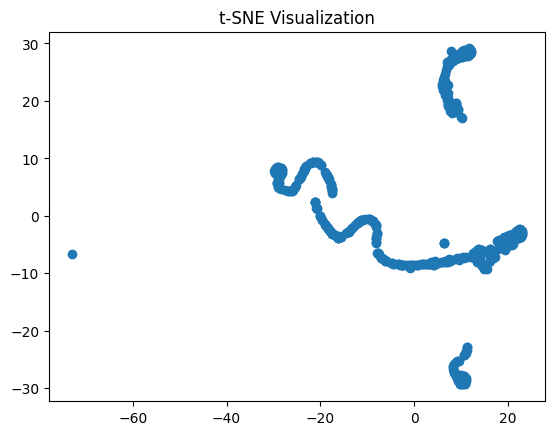

In [ ]:
from sklearn.manifold import TSNE

# Reduce dimensionality of embeddings for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot the t-SNE visualization
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.title('t-SNE Visualization')
plt.show()


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the path to save the model
save_path = '/content/drive/MyDrive/model_efficentnet.h5'

# Save the model as an H5 file
model.save(save_path)
print("Model saved successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved successfully.
